# Интернет-магазин. A/B-тест. 

В данном проекте будем работать с данными интернет-магазина, нам предстоит выбрать наиболее приоритетные гипотезы и проанализировать результаты A/B-теста. В наличие три таблицы: таблица с гипотезами, данные о покупках и данные о посещениях интернет-магазина. Сначала познакомимся с данными, преобразуем данные, если потребуется, далее применим фреймворки ICE и RICE для приоритизации гипотез, после чего проанализируем результаты А/В-теста с помощью статистических методов. В итоге сделаем общий вывод о проведенном анализе, решим, был ли А/В тест успешен. 

## Знакомство с данными. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from pandas.plotting import register_matplotlib_converters
import math as mth 
import scipy.stats as stats
import numpy as np 
import datetime as dt 
import warnings 
warnings.simplefilter('ignore')

In [2]:
try: 
    hypothesis= pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv') 
    visitors = pd.read_csv('/datasets/visitors.csv')
except: 
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
# создадим функцию для первичного анализа датафреймов
def explore(dataset):
    dataset.columns = [x.lower() for x in dataset.columns]
    print("Describe: \n", dataset.describe())
    print('*'*50)
    print("Info: \n", dataset.info())
    print('*'*50)
    print("Head: \n", dataset.head())
    print('*'*50)
    print(f'Количество дубликатов: {dataset.duplicated().sum()}')

### Hypothesis

In [4]:
explore(hypothesis)

Describe: 
            reach     impact  confidence    efforts
count   9.000000   9.000000    9.000000   9.000000
mean    4.777778   4.777778    5.555556   4.888889
std     3.153481   3.192874    3.045944   2.803767
min     1.000000   1.000000    1.000000   1.000000
25%     3.000000   3.000000    3.000000   3.000000
50%     3.000000   3.000000    7.000000   5.000000
75%     8.000000   7.000000    8.000000   6.000000
max    10.000000  10.000000    9.000000  10.000000
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Info: 
 None
******************************

В таблице 9 гипотез, нет пропусков и дупликатов. Названия столбцов привели к нижнему регистру. 

### Orders

In [5]:
explore(orders)

Describe: 
        transactionid     visitorid       revenue
count   1.197000e+03  1.197000e+03  1.197000e+03
mean    2.155621e+09  2.165960e+09  8.348006e+03
std     1.229085e+09  1.236014e+09  3.919113e+04
min     1.062393e+06  5.114589e+06  5.000000e+01
25%     1.166776e+09  1.111826e+09  1.220000e+03
50%     2.145194e+09  2.217985e+09  2.978000e+03
75%     3.237740e+09  3.177606e+09  8.290000e+03
max     4.293856e+09  4.283872e+09  1.294500e+06
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Info: 
 None
*************************

In [6]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

В таблице orders 1197 заказов, нет пропусков и дупликатов. Тип данных в столбце date изменили на тип datetime. Названия столбцов привели к нижнему регистру. 

### Visitors

In [7]:
explore(visitors)

Describe: 
          visitors
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
Info: 
 None
**************************************************
Head: 
          date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
3  2019-08-04     A       717
4  2019-08-05     A       756
**************************************************
Количество дубликатов: 0


In [8]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

В таблице visitors 62 даты, нет пропусков и дупликатов. Тип данных в столбце date изменили на тип datetime. Названия столбцов привели к нижнему регистру. Среднее значение по количеству пользователей в день - 607, максимум - 770.

In [9]:
# посчитаем кол-во уникальных пользователей в группе А

orders_a = orders[orders['group'] == 'A']
orders_a['visitorid'].nunique()

503

In [10]:
# посчитаем кол-во уникальных пользователей в группе В
orders_b = orders[orders['group'] == 'B']
orders_b['visitorid'].nunique()

586

In [11]:
# определим, есть ли пользователи, которые попали в обе группы 

orders_b['visitorid'].isin(orders_a['visitorid']).value_counts()

False    548
True      92
Name: visitorid, dtype: int64

In [12]:
merged_orders = orders_a.merge(orders_b, how='inner', on='visitorid')
merged_visitors = merged_orders['visitorid'].unique()

Есть 92 пользователя, которые попали в группы А и В. Так как мы не можем выявить данных пользователей в таблицу visitors, удалять этих пользователей из анализа не будем. 

## Приоритизация гипотез 

Будем использовать фреймворк RICE для приоритизации гипотез, все гипотезы невыгодно и бесмысленно проверять, поэтому на основе 4 компонент будем делать расчет:

Reach — скольких пользователей затронет изменение;

Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;

Confidence — насколько мы уверены, что это изменение повлияет на пользователей именно так; 

Efforts — сколько стоит протестировать эту гипотезу. 


### ICE 

In [13]:
pd.options.display.max_colwidth = 200

hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [14]:
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


В ТОП-5 попали: 8, 0, 7, 6, 2 гипотезы. 

### RICE 

In [15]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [16]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
hypothesis[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False).style.background_gradient(cmap=cm)

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


В ТОП-5 те же гипотезы, только 8 гипотеза теперь на 5 месте, а не на 1 месте, 2 гипотеза вышла на 2 место. Изменения произошли из-за критерия Reach: возможно охват 8 гипотезы значительно ниже четырех других гипотез, в то время как охват 7 гипотезы настолько большой, что показатель RICE сильно выше остальных, у 2 гипотезы показатель в 2 раза меньше.

## Анализ A/B-теста

### Кумулятивная выручка по группам

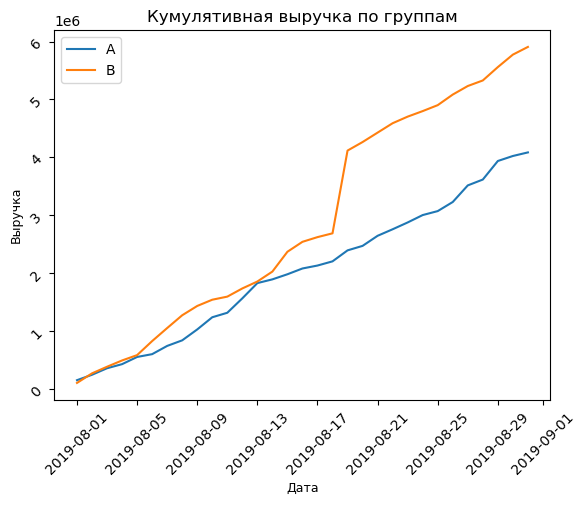

In [17]:
register_matplotlib_converters()

datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date': 'max','group': 'max','transactionid': 'nunique','visitorid': 'nunique','revenue': 'sum'}),axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])
].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors']

cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Выручка', fontsize=9)
plt.tick_params(rotation=45)
plt.legend()
plt.show()

Кумулятивная выручка в группе В лидирует на протяжении всего теста. Есть два явных скачка, после которых выручка в группе В сильно больше выручки в группе А.

### Кумулятивный средний чек по группам

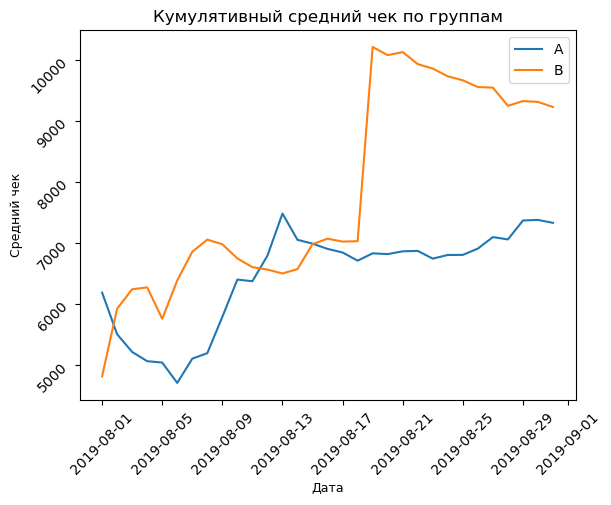

In [18]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Средний чек', fontsize=9)
plt.tick_params(rotation=45)
plt.legend()
plt.show()

Средний чек в группе В больше среднего чека в группе А на протяжении почти всего теста, за исключением дня старта и нескольких дней в середине теста. Возможно около 17 марта были крупные заказы или заказ, после которого средний чек в группе В сильно увеличился.

### Относительное изменение кумулятивного среднего чека группы B к группе A

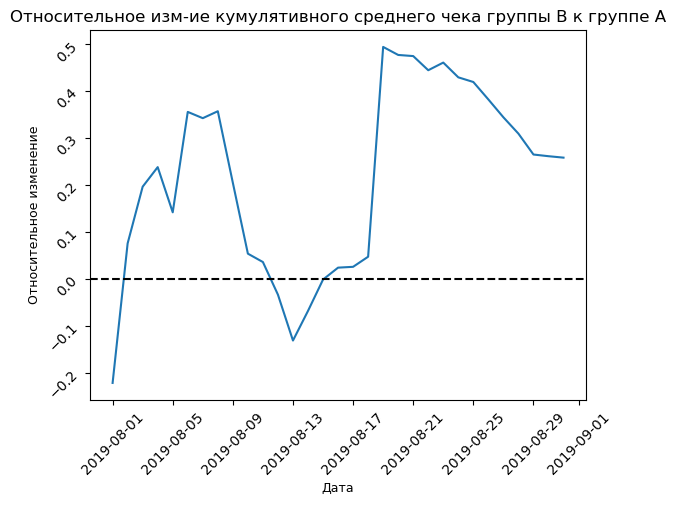

In [19]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on = 'date', 
                                                   how = 'left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / 
         (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)
plt.title('Относительное изм-ие кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Относительное изменение', fontsize=9)
plt.tick_params(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')

Относительное изменение больше 20% на протяжении почти всего теста за исключением тех же нескольких дней. 

### Кумулятивное среднее количество заказов на посетителя по группам

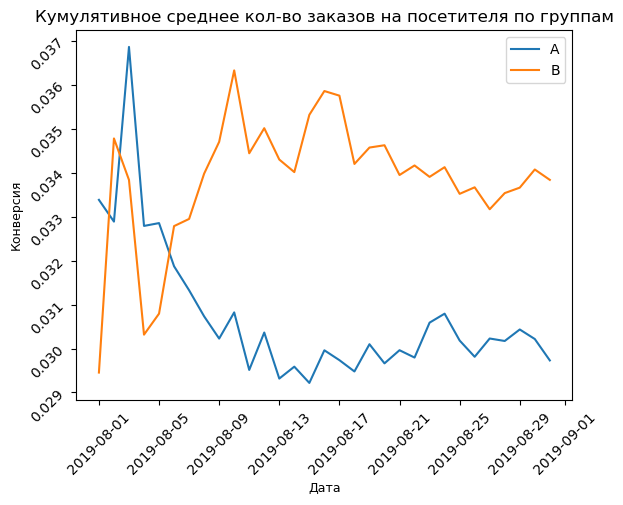

In [20]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивное среднее кол-во заказов на посетителя по группам')
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Конверсия', fontsize=9)
plt.tick_params(rotation=45)
plt.legend()

В начале теста группа А показывала большую конверсию, но после 5 августа конверсия в группе В установилась примерно на уровне 0.033. В группе А - около 0.03.

### Относительное изм-ие кумулятивного среднего количества заказов на посетителя группы B к группе A

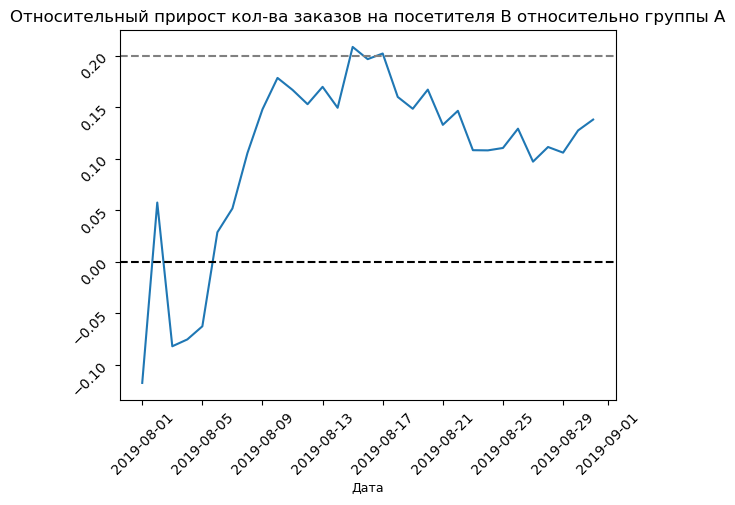

In [21]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], left_on='date', right_on = 'date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/ mergedCumulativeConversions['conversionA'] - 1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.title('Относительный прирост кол-ва заказов на посетителя B относительно группы A')
plt.xlabel('Дата', fontsize=9)
plt.tick_params(rotation=45)
plt.show()

После 5 августа группа В лидирует по количеству заказов на посетителя.

### Количество заказов по пользователям

Text(0.5, 1.0, 'Количество заказов по пользователям')

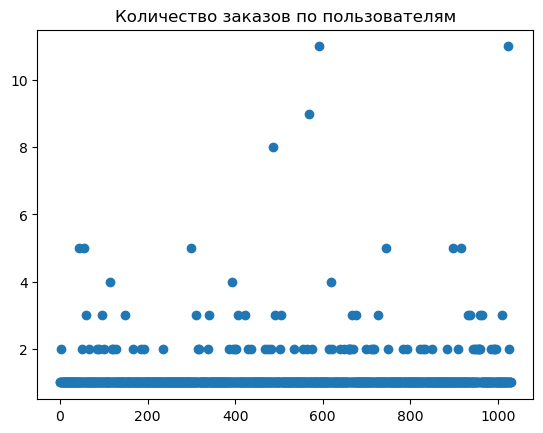

In [22]:
ordersByUsers = (orders.groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'}))
ordersByUsers.columns = ['userId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям')

Судя по графику, пользователей, которые сделали более 2 заказов сильно меньше, чем тех, кто сделал 1 или 2 заказа. 

In [23]:
# исключим из таблицы orders пользователей, которые попали в обе группы
orders_unique = orders.query('visitorid not in @merged_visitors')

ordersByUsers_unique = (orders_unique.groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'}))
ordersByUsers_unique.columns = ['userId', 'orders']

### 95-й и 99-й перцентили количества заказов на пользователя

In [24]:
np.percentile(ordersByUsers['orders'], [95,99])

array([2., 4.])

Не более 5% пользователей совершали более 2 заказов и не более 1% пользователей - более 4 заказов.

In [25]:
# рассчитаем те же перцентили для очищенной таблицы
np.percentile(ordersByUsers_unique['orders'], [95,99])

array([1., 2.])

Не более 5% пользователей совершали больше 1 заказа и не более 1% пользователей - более 2 заказов.

### Стоимость заказов

(0.0, 100000.0)

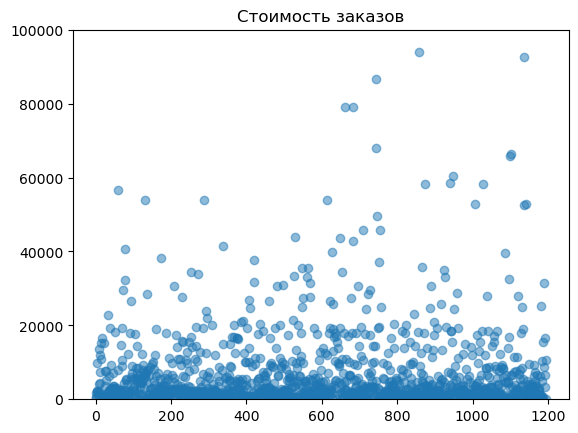

In [26]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('Стоимость заказов')
plt.ylim(0, 100000)

Стоимость заказов на сумму больше 30-40 тыс не так много, есть выбросы со стоимостью 80 и 100 тыс рублей. 

### 95-й и 99-й перцентили стоимости заказов

In [27]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более, чем у 5% заказов чек дороже 28000 рублей, не более чем у 1% заказов - дороже 58233 рублей. 

In [28]:
# рассчитаем те же перцентили для очищенной таблицы
np.percentile(orders_unique['revenue'], [95, 99])

array([26785., 53904.])

Не более, чем у 5% заказов чек дороже 26785 рублей, не более чем у 1% заказов - дороже 53904 рублей. 

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

In [29]:
# рассчитаем количество пользователей в выбранную дату в группе А

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# рассчитаем количество пользователей до выбранной даты включительно в группе B.

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# рассчитаем количество пользователей в выбранную дату в группе B

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# рассчитаем количество пользователей до выбранной даты включительно в группе B.

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# рассчитаем количество заказов в выбранную дату в группе A

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# рассчитаем суммарное число заказов до выбранной даты включительно в группе A

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
{'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA']

# рассчитаем количество заказов в выбранную дату в группе В

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# рассчитаем суммарное число заказов до выбранной даты включительно в группе В

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB']

data = (ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

# создадим переменные для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

ordersByUsersA = (orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = (orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
ordersByUsersB.columns = ['visitorid', 'orders']


Сформулируем гипотезы.

H0: различий в среднем количестве заказов между группами нет. 

H1: различия в среднем между группами есть.

In [30]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("P-value - {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительное изменение - {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value - 0.01679
Относительное изменение - 0.138


P-value меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ по "сырым" данным показывает, что есть статистически значимые различия между группами в разрезе среднего количества заказов. Относительный прирост среднего группы В к группе А - 13.8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы.

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть.

In [31]:
print('p-value - {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('относительное изменение - {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value - 0.729
относительное изменение - 0.259


P-value сильно больше 0.05, нулевую гипотезу отвергнуть не можем, статистически значимых различий по среднему чеку между группами нет. Хотя относительно различие среднего чека чуть больше 25%, что оказалось не статистически значимым. 

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

In [32]:
orders_limit = 2

usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['orders'] > orders_limit]['visitorid'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_limit]['visitorid']], axis=0)

revenue_limit = 28000
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_limit]['visitorid']

abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())

# исключим тех, кто совершал больше, чем 2 заказа, и тех, у кого заказы были стоимостью больше чем 28 тыс руб. 

In [33]:
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))]['orders'],
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)

print('p-value - {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительное изменение - {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value - 0.01304
относительное изменение - 0.173


Результат тот же, нулевую гипотезу отвергаем, есть статическая значимость. Относительный прирост чуть меньше - 17.3%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [34]:
print('p-value - {0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]))

print("относительное изменение - {0:.3f}".format(orders[np.logical_and(orders['group'] == 'B',
                              np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value - 0.738
относительное изменение - -0.020


Также нет статистически значимых различий в среднем чеке между группами. Присутствует даже относительный спад в 2%, который получается не статически значимый.

### Общий вывод

Тест показал, что есть статитистически значимые различия в среднем количеством заказов между группами, но нет статистически значимых различий в среднем чеке. То есть, пользователи в среднем совершают бОльшее количество заказов, но эти заказы в среднем по стоимости такие же, что и заказы в группе А. Тест можно остановить и зафиксировать победу группы В, к 29 августа такие показатели как среднее количество заказов и конверсия зафиксировались на определенном уровне. \
Также отметим, что 92 пользователя попали в группы А и В, из данных они не были исключены. 